# Import relevant libraries

In [1]:
import os
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
# disable false positive warnings
pd.options.mode.chained_assignment = None

# Setup path

In [3]:
# set up paths
base_path = '../datasets'
cleaned_data_path = os.path.join(base_path, 'cleaned_data')

# Load data

In [4]:
node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))
perf_eval_df = pd.read_csv(os.path.join(cleaned_data_path, 'perf_eval_table.csv'))

In [5]:
print(f'number of observation: {len(node_edge_df)}')
node_edge_df.head()

number of observation: 163001


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year
0,Fortuna Sittard,Rene Hofman,31.0,Right Winger,Roda JC,?,in,NaN,1992
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,NaN,1992
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,NaN,1992
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,0.0,1992
4,Fortuna Sittard,Jerry Taihuttu,22.0,Centre-Forward,Helmond Sport,Loan,out,0.0,1992


# Analysis

**Thesis Statement:**

Workflow:
1) Step1  
2) Step2  
3) Step3  

**To do**
- There seems to be a trend on age-price so we dev scaling factor (average price by age with base age) to diminish the effect of age on price.
- Identify the effect of homophily (Membership closure) on performance -> performance metric = f(price, scaling_factor) and maybe with combination of other metrics
- Identify the behavior of the transfer if it's related to our analysis,   
  - if yes: the analysis might be the cause  
  - if no: give some recommendation

## Fee-Age Analysis

In [45]:
fee_age = perf_eval_df[['age', 'fee_cleaned']]
fee_age

,age,fee_cleaned
0,19.0,0.817
1,21.0,0.013
2,25.0,1.170
3,21.0,0.005
4,19.0,0.817
...,...,...
26589,25.0,2.250
26590,23.0,4.500
26591,23.0,0.450
26592,28.0,2.480


<AxesSubplot:xlabel='age', ylabel='fee_cleaned'>

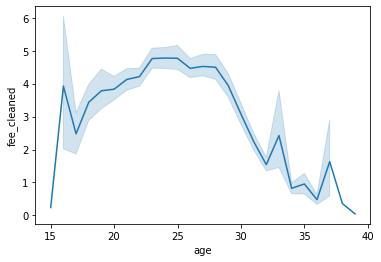

In [46]:
# the variance is quite high
sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.mean, ci = 95)

<AxesSubplot:xlabel='fee_cleaned', ylabel='Count'>

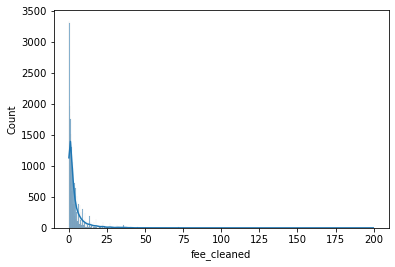

In [47]:
# heavy-tailed distribution --> median would be a more sensible mid-point measure
# as mean would be influenced by the outliers
sns.histplot(fee_age['fee_cleaned'], kde = True)

In [48]:
# descriptive statistics
desc_stat = fee_age.groupby('age')['fee_cleaned']\
                   .agg(['mean', 'median', 'std', 'min', 'max', 'count'])
# remove group with small number of observations
desc_stat = desc_stat[desc_stat['count'] > 100]

In [49]:
# There are some outliers that greatly influence the mean and thus using median is more robust
desc_stat

,mean,median,std,min,max,count
age,,,,,,
17.0,2.476510,0.990,3.844370,0.005,21.60,145
18.0,3.433969,1.350,6.202667,0.002,40.50,512
19.0,3.783434,1.350,9.608391,0.005,130.50,1052
20.0,3.830943,1.580,7.183568,0.009,124.20,1605
21.0,4.126564,1.530,7.276784,0.005,79.38,2169
22.0,4.212821,1.620,6.906991,0.004,67.50,2549
23.0,4.760516,1.980,8.301757,0.009,94.50,2802
24.0,4.775991,1.980,8.126826,0.008,90.90,2771
25.0,4.769627,2.120,9.505160,0.009,199.80,2594


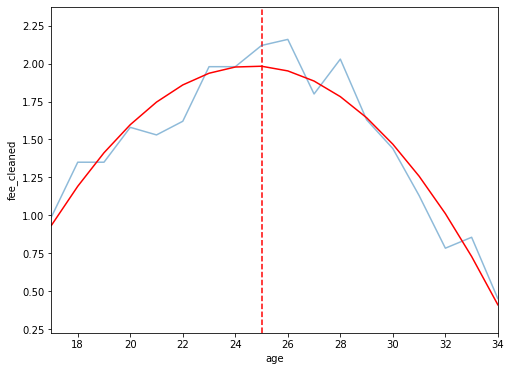

In [50]:
# visualize
fig, ax = plt.subplots(figsize = (8, 6))

sns.lineplot(data = fee_age, x = 'age', y = 'fee_cleaned', estimator= np.median, ci = None, alpha = 0.5)

xlim = (desc_stat.index[0], desc_stat.index[-1])
ylim = (min(desc_stat['median']*0.5), max(desc_stat['median'])*1.1)

# fit polynomial to smoothen the trend (for adjustment coefficient)
x = list(desc_stat['median'].index)
y = list(desc_stat['median'])

# smoothen the liner
fit = np.polyfit(x, y, deg = 2)
poly1d = np.poly1d(fit)

# add adjustment line
plt.plot(x, poly1d(x), '-', c = 'red')

# get the turning point (slope < 0)
idx = [idx for idx,val in enumerate(np.diff(poly1d(x))) if val < 0][0]

# add vertical line at the turning point
plt.vlines(x = x[idx], ymin = ylim[0], ymax = ylim[1],
           colors = 'red', linestyles = 'dashed')

ax.set_xlim(xlim)
ax.set_ylim(ylim)

plt.show()

In [51]:
# develop adjustment coefficient
fitted_value = poly1d(x)

baseline = fitted_value[0]
base_value = np.divide(fitted_value, baseline)
coef = np.reciprocal(base_value)

temp_df = pd.DataFrame(data = {'age': desc_stat['median'].index,
                               'coef': coef})
temp_df

,age,coef
0,17.0,1.000000
1,18.0,0.784209
2,19.0,0.661457
3,20.0,0.584819
4,21.0,0.534897
5,22.0,0.502366
6,23.0,0.482366
7,24.0,0.472339
8,25.0,0.471119
9,26.0,0.478570


In [52]:
# extend age range to cover the data using lower-upper bound coefficient
age_df = pd.DataFrame(data = {'age': sorted(fee_age['age'].unique())})
adj_coef_table = pd.merge(age_df, temp_df, on = 'age', how = 'left')
adj_coef_table['coef'] = adj_coef_table['coef'].interpolate(method = 'linear', limit_direction = 'both')
adj_coef_table

,age,coef
0,15.0,1.000000
1,16.0,1.000000
2,17.0,1.000000
3,18.0,0.784209
4,19.0,0.661457
5,20.0,0.584819
6,21.0,0.534897
7,22.0,0.502366
8,23.0,0.482366
9,24.0,0.472339


## Homophily Analysis

In [6]:
print(f'number of observation: {len(node_edge_df)}')
node_edge_df.head()

number of observation: 163001


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year
0,Fortuna Sittard,Rene Hofman,31.0,Right Winger,Roda JC,?,in,NaN,1992
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,NaN,1992
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,NaN,1992
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,0.0,1992
4,Fortuna Sittard,Jerry Taihuttu,22.0,Centre-Forward,Helmond Sport,Loan,out,0.0,1992


### Create structured data

In [7]:
# 2 components needed: 'year_list', 'club_list'
year_list = sorted(sorted(node_edge_df['year'].unique()))
club_list = sorted(node_edge_df['club_name'].unique())

In [8]:
# define function to remove elements in a list from another list
def remove_elem_by_list(list1, list2):
    for elem in list2:
        try:
            list1.remove(elem)
        except Exception:
            pass
    return list1

In [9]:
# nested dictionary: year: `club_member`
nested_dict = {}
prev_year = None

# loop over year:
for year in tqdm(year_list):

    if prev_year in nested_dict.keys():

        # retrieve club-player info in the previous year for the second year and so on
        club_member = copy.deepcopy(nested_dict[prev_year])

    else:
        # initiate a dictionary of clubs (keys) and their affiliated players (values)
        club_member = {}

    # subset data by year
    data = node_edge_df[node_edge_df['year'] == year]

    # subset for transfer_movement == 'in', 'out'
    data_in = data[data['transfer_movement'] == 'in']
    data_out = data[data['transfer_movement'] == 'out']

    # loop over club:
    for club in club_list:

        # subset data by club
        temp_data_in = data_in[data_in['club_name'] == club]
        temp_data_out = data_out[data_out['club_name'] == club]

        # update all players in that club in the dictionary (`club_member`)
        player_list_in = list(temp_data_in['player_name'])
        player_list_out = list(temp_data_out['player_name'])

        if prev_year in nested_dict.keys():

            # catch bug (The case when club has no member yet)
            if club_member[club] is None:
                club_member[club] = []

            # adjust for members who move in
            club_member[club].extend(player_list_in)
            # adjust for members who move out
            remove_elem_by_list(club_member[club], player_list_out)

        else:
            # update club_member info
            club_member[club] = remove_elem_by_list(player_list_in,
                                                    player_list_out)

    # store `club_member` in `nested_dict`
    nested_dict[year] = club_member

    # set previous year
    prev_year = year

### Analysis

In [10]:
# subset only `transfer_movement` == 'in'; we want to analyze the number of ties a player has
# before entering a team
df = node_edge_df[node_edge_df['transfer_movement'] == 'in']
df.reset_index(drop=True, inplace=True)
# clean the table
df.drop_duplicates(inplace=True)

In [11]:
# add column `num_transfer` which represent the number of time a player moved
df['count'] = 1
df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(
    np.max)
df.drop(columns='count', inplace=True)
print(f'number of observation: {len(df)}')
df.head()

number of observation: 78625


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer
0,Fortuna Sittard,Rene Hofman,31.0,Right Winger,Roda JC,?,in,NaN,1992,1,1
1,Fortuna Sittard,Peter Schmitz,21.0,Forward,Helmond Sport,?,in,NaN,1992,1,1
2,Fortuna Sittard,Kenneth Nysaether,22.0,Centre-Forward,Lillestrøm SK,?,in,NaN,1992,1,1
3,Fortuna Sittard,Arno van Zwam,22.0,Goalkeeper,Fortuna U19,-,in,0.0,1992,1,2
4,Dordrecht'90,Michel Langerak,23.0,Attacking Midfield,VVV-Venlo,?,in,NaN,1992,1,3


In [13]:
# get player_list
player_list = list(df['player_name'].unique())
print(f'Number of players: {len(player_list)}')
print(f'Number of clubs: {len(df.club_name.unique())}')

Number of players: 28976
Number of clubs: 401


In [14]:
# initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
was_in = {}

# loop over the dataset
for player in tqdm(player_list):

    # subset df by player
    temp_df = df[df['player_name'] == player]

    # reset_index
    temp_df.reset_index(drop=True, inplace=True)

    # initiate inside dictionaries
    aff_clubs = {}
    """
    loop over the dataset to get the year and club name 
    this represent that a player stay in a club from year A - year B 
    in this case, we can ignore the last row because no further analysis is needed
    as the next transaction has not occurred yet
    """

    for row in range(len(temp_df) - 1):

        # initiate inside dictionaries
        year_member = {}

        club_name = temp_df.iloc[row]['club_name']

        year_list = np.arange(temp_df.iloc[row]['year'],
                              temp_df.iloc[row + 1]['year'])

        # get the affiliated player each year from `nested_dict`
        for year in year_list:

            # just in case some years are missing
            if year not in nested_dict.keys():

                pass

            else:

                aff_players = nested_dict[year][club_name]

                # add data to `year_member`
                year_member[year] = aff_players

        # add data to aff_club

        # adjust for the case when player moves back to the club he's been before
        if club_name in aff_clubs.keys():

            aff_clubs[club_name].update(year_member)

        else:

            aff_clubs[club_name] = year_member

    # add data to was_in
    was_in[player] = aff_clubs

In [15]:
# was_in

In [16]:
# table we will use
df.sort_values(['player_name', 'num_transfer'], inplace=True)
df.reset_index(drop=True, inplace=True)
print(f'number of observation: {len(df)}')
df.head()

number of observation: 78625


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer
0,AS Monaco,Aadil Assana,20.0,Defensive Midfield,Clermont Foot,"End of loanJun 30, 2013",in,0.000,2013,1,2
1,AS Monaco,Aadil Assana,20.0,Defensive Midfield,CA Bastia,"End of loanJan 20, 2014",in,0.000,2013,2,2
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2
4,Bristol City,Aaron Amadi-Holloway,18.0,Centre-Forward,Bristol City U18,-,in,0.000,2011,1,2


In [17]:
# generate `k` column

# initiate a list
k = []
k_names = []

# loop over the dataset
for i in tqdm(range(len(df))):

    # there is nothing to do with the `k` for the first transfer
    if df['num_transfer'][i] == 1:

        k.append(None)
        k_names.append([])

    else:

        # get necessary variables (keys)
        player = df['player_name'][i]
        prev_club = df['club_name'][i - 1]
        club = df['club_name'][i]
        prev_year = df['year'][i - 1]
        this_year = df['year'][i]
        year_range = np.arange(prev_year, this_year)

        # get all the affiliated players
        aff_players = []
        for year in year_range:

            # just in case some years are missing
            if year not in nested_dict.keys():

                pass

            else:

                aff_player = was_in[player][prev_club][year]
                aff_players.extend(aff_player)

        # get all member in the club player is joining
        in_club_player = nested_dict[this_year][club]

        if df['num_transfer'][i] > 2:
            # accumulate affiliated players
            aff_players = set.union(set(prev_set), set(aff_players))

        # get `k_names`, `k_val`
        k_name = list(
            set.intersection(set(aff_players), set(in_club_player)) -
            set([player]))
        k_val = len(k_name)

        # append data
        k_names.append(k_name)
        k.append(k_val)

        # previous affiliated player set
        prev_set = set(aff_players)

# add `k` column
df['k'] = k
# add `k_name` column
df['k_name'] = k_names

In [22]:
# get k-pk table
k_count = df[['k']].dropna()
k_count['count'] = 1
k_count = pd.DataFrame(k_count.groupby('k')['count'].agg('count'))
k_count.reset_index(inplace=True)
k_count['pk'] = k_count['count'] / sum(k_count['count'])

k_pk = k_count
# hardcode: further `k` does not seem relevant anymore
xmax = 6
k_pk = k_pk[k_pk['k'] <= xmax]
k_pk

,k,count,pk
0,0.0,19685,0.396483
1,1.0,7430,0.149651
2,2.0,3280,0.066064
3,3.0,1505,0.030313
4,4.0,751,0.015126
5,5.0,462,0.009305
6,6.0,338,0.006808


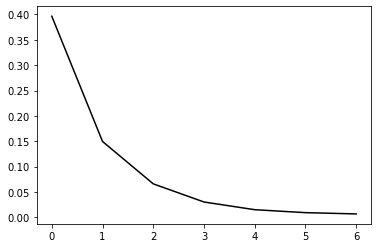

In [24]:
plt.plot(k_pk['k'], k_pk['pk'], color='black')

### Test the existence of homophily

#### Null case simulation
In this section, we simulated 10 random networks for the football data. Here are some important features:
1) The simulated data follow the same proportion of the number of transfers by players in the network  
2) The simulated data assume players only transfer within the 8 major leagues and are always in a club until 2020 (No retire or without club)

In [20]:
# # load data
# node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))

In [21]:
# #select only necessary columns
# data_simul = node_edge_df[['player_name', 'club_name', 'transfer_movement', 'year']]

In [ ]:
# data_simul

In [ ]:
# len(data_simul)

In [ ]:
# # set-up

# player_name_list = data_simul['player_name'].unique()
# club_name_list = data_simul['club_name'].unique()
# year_list = data_simul['year'].unique()

# # in-out distribution (just get the `in` and multiply by 2: assume that the data is cleaned)
# in_num = sum(data_simul['transfer_movement'] == 'in')

# # number of movement distribution
# num_move = pd.DataFrame(data_simul.groupby(['player_name', 'year'])['transfer_movement'].agg('count'))
# num_move['count'] = 1
# num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
# num_move = pd.DataFrame(num_move).reset_index()
# num_move['transfer_movement'] = [math.ceil(num/2) for num in num_move['transfer_movement']]
# num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
# num_move = num_move / np.sum(num_move)
# num_move = round(num_move * in_num)
# num_move = pd.DataFrame(num_move).reset_index()

In [ ]:
# num_move

In [ ]:
# # get column names
# col_names = data_simul.columns

# # simulate data
# rows = []
# for t, count in zip(num_move['transfer_movement'], num_move['count']):
#     for i in tqdm(range(int(count))):
#         # get each column value
#         player_name = np.repeat(np.random.choice(player_name_list, 1), t)
#         club_name = np.random.choice(club_name_list, t, replace = False)
#         transfer_movement = np.repeat('in', t)
#         year = np.random.choice(year_list, t, replace = False)
#         # format data
#         row = list(zip(player_name, club_name, transfer_movement, year))
#         # add to the list
#         rows.extend(row)

# # create dataframe
# null_case = pd.DataFrame(data = rows, columns = col_names)
# print(f'number of observation: {len(null_case)}')
# null_case.head()

In [ ]:
# # sort data
# null_case = null_case.sort_values(by = ['player_name', 'year'])

# # add column `num_transfer` which represent the number of time a player moved
# null_case['count'] = 1
# null_case['num_transfer'] = null_case.groupby('player_name')['count'].cumcount() + 1
# null_case['max_transfer'] = null_case.groupby('player_name')['num_transfer'].transform(np.max)
# null_case.drop(columns = 'count', inplace = True)
# null_case.reset_index(drop = True, inplace = True)
# print(f'number of observation: {len(null_case)}')
# null_case

In [ ]:
# # add `transfer_movement` == 'out'
# to_add = []
# for i in tqdm(range(len(null_case))):
#     if (null_case.iloc[i]['num_transfer'] > 1) & \
#     (null_case.iloc[i]['num_transfer'] < null_case.iloc[i]['max_transfer']):
#         # create the 'out' case
#         row = list(null_case.iloc[i].replace('in', 'out'))
#         # add to `to_add` list
#         to_add.append(row)

# # add data to dataframe
# extend = pd.DataFrame(data = to_add, columns = null_case.columns)
# null_case = pd.concat([null_case, extend], axis = 0).reset_index(drop = True)
# null_case.drop(columns = ['num_transfer', 'max_transfer'], inplace = True)
# null_case.sort_values(by = ['player_name', 'year']).reset_index(drop = True, inplace = True)
# null_case

#### Null case analysis

In [ ]:
# # 2 components needed: 'year_list', 'club_list'
# year_list = sorted(sorted(null_case['year'].unique()))
# club_list = sorted(null_case['club_name'].unique())

In [ ]:
# # nested dictionary: year: `club_member`
# nested_dict = {}
# prev_year = None

# # loop over year:
# for year in tqdm(year_list):

#     if prev_year in nested_dict.keys():

#         # retrieve club-player info in the previous year for the second year and so on
#         club_member = copy.deepcopy(nested_dict[prev_year])

#     else:
#         # initiate a dictionary of clubs (keys) and their affiliated players (values)
#         club_member = {}

#     # subset data by year
#     data = null_case[null_case['year'] == year]

#     # subset for transfer_movement == 'in', 'out'
#     data_in = data[data['transfer_movement'] == 'in']
#     data_out = data[data['transfer_movement'] == 'out']

#     # loop over club:
#     for club in club_list:

#         # subset data by club
#         temp_data_in = data_in[data_in['club_name'] == club]
#         temp_data_out = data_out[data_out['club_name'] == club]

#         # update all players in that club in the dictionary (`club_member`)
#         player_list_in = list(temp_data_in['player_name'])
#         player_list_out = list(temp_data_out['player_name'])

#         if prev_year in nested_dict.keys():

#             # catch bug
#             if club_member[club] is None:
#                 club_member[club] = []

#             # adjust for members who move in
#             club_member[club].extend(player_list_in)
#             # adjust for members who move out
#             remove_elem_by_list(club_member[club], player_list_out)

#         else:
#             # update club_member info
#             club_member[club] = remove_elem_by_list(player_list_in, player_list_out)

#     # store `club_member` in `nested_dict`
#     nested_dict[year] = club_member

#     # set previous year
#     prev_year = year

In [ ]:
# df = null_case[null_case['transfer_movement'] == 'in']

In [ ]:
# # add column `num_transfer` which represent the number of time a player moved
# df['count'] = 1
# df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
# df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
# df.drop(columns = 'count', inplace = True)
# print(f'number of observation: {len(df)}')
# df

In [ ]:
# # get player_list
# player_list = list(df['player_name'].unique())
# print(f'Number of players: {len(player_list)}')
# print(f'Number of clubs: {len(df.club_name.unique())}')

In [ ]:
# # initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
# was_in = {}

# # loop over the dataset
# for player in tqdm(player_list):

#     # subset df by player
#     temp_df = df[df['player_name'] == player]

#     # reset_index
#     temp_df.reset_index(drop = True, inplace = True)

#     # initiate inside dictionaries
#     aff_clubs = {}

#     """
#     loop over the dataset to get the year and club name
#     this represent that a player stay in a club from year A - year B
#     in this case, we can ignore the last row because no further analysis is needed
#     as the next transaction has not occurred yet
#     """

#     for row in range(len(temp_df) - 1):

#         # initiate inside dictionaries
#         year_member = {}

#         club_name = temp_df.iloc[row]['club_name']

#         year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])

#         # get the affiliated player each year from `nested_dict`
#         for year in year_list:

#             # just in case some years are missing
#             if year not in nested_dict.keys():

#                 pass

#             else:

#                 aff_players = nested_dict[year][club_name]

#                 # add data to `year_member`
#                 year_member[year] = aff_players

#         # add data to aff_club

#         # adjust for the case when player moves back to the club he's been before
#         if club_name in aff_clubs.keys():

#                 aff_clubs[club_name].update(year_member)

#         else:

#             aff_clubs[club_name] = year_member

#     # add data to was_in
#     was_in[player] = aff_clubs

In [ ]:
# # table we will use
# df.sort_values(['player_name', 'num_transfer'], inplace = True)
# df.reset_index(drop = True, inplace = True)
# df

In [ ]:
# # generate `k` column

# # initiate a list
# k = []
# k_names = []

# # loop over the dataset
# for i in tqdm(range(len(df))):

#     # there is nothing to do with the `k` for the first transfer
#     if df['num_transfer'][i] == 1:

#         k.append(None)
#         k_names.append([])

#     else:

#         # get necessary variables (keys)
#         player = df['player_name'][i]
#         prev_club = df['club_name'][i-1]
#         club = df['club_name'][i]
#         prev_year = df['year'][i-1]
#         this_year = df['year'][i]
#         year_range = np.arange(prev_year, this_year)

#         # get all the affiliated players
#         aff_players = []
#         for year in year_range:

#             # just in case some years are missing
#             if year not in nested_dict.keys():

#                 pass

#             else:

#                 aff_player = was_in[player][prev_club][year]
#                 aff_players.extend(aff_player)

#         # get all member in the club player is joining
#         in_club_player = nested_dict[this_year][club]

#         if df['num_transfer'][i] > 2:
#             # accumulate affiliated players
#             aff_players = set.union(set(prev_set), set(aff_players))

#         # get `k_names`, `k_val`
#         k_name = list(set.intersection(set(aff_players), set(in_club_player)) - set([player]))
#         k_val = len(k_name)

#         # append data
#         k_names.append(k_name)
#         k.append(k_val)

#         # previous affiliated player set
#         prev_set = set(aff_players)

# # add `k` column
# df['k'] = k
# # add `k_name` column
# df['k_name'] = k_names

In [ ]:
# # get k-pk table
# k_count = df[['k']].dropna()
# k_count['count'] = 1
# k_count = pd.DataFrame(k_count.groupby('k')['count'].agg('count'))
# k_count.reset_index(inplace = True)
# k_count['pk'] = k_count['count'] / sum(k_count['count'])

# k_pk = k_count
# # hardcode: further `k` does not seem relevant anymore
# # xmax = 6
# # k_pk = k_pk[k_pk['k'] <= xmax]
# k_pk

In [ ]:
# plt.bar(k_pk['k'],
#          k_pk['pk'],
#          color = 'black')

#### Iteration

In [20]:
# # set seed
# np.random.seed(777)

# # simulate data 10 times
# t = 10

# for n in tqdm(range(t)):
#     # load data
#     node_edge_df = pd.read_csv(os.path.join(cleaned_data_path, 'node_edge_data.csv'))

#     #select only necessary columns
#     data_simul = node_edge_df[['player_name', 'club_name', 'transfer_movement', 'year']]

#     # set-up
#     player_name_list = data_simul['player_name'].unique()
#     club_name_list = data_simul['club_name'].unique()
#     year_list = data_simul['year'].unique()

#     # in-out distribution (just get the `in` and multiply by 2: assume that the data is cleaned)
#     in_num = sum(data_simul['transfer_movement'] == 'in')

#     # number of movement distribution
#     num_move = pd.DataFrame(data_simul.groupby(['player_name', 'year'])['transfer_movement'].agg('count'))
#     num_move['count'] = 1
#     num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
#     num_move = pd.DataFrame(num_move).reset_index()
#     num_move['transfer_movement'] = [math.ceil(num/2) for num in num_move['transfer_movement']]
#     num_move = num_move.groupby('transfer_movement')['count'].agg('sum')
#     num_move = num_move / np.sum(num_move)
#     num_move = round(num_move * in_num)
#     num_move = pd.DataFrame(num_move).reset_index()

#     # get column names
#     col_names = data_simul.columns

#     # simulate data
#     rows = []
#     for t, count in zip(num_move['transfer_movement'], num_move['count']):
#         for i in tqdm(range(int(count))):
#             # get each column value
#             player_name = np.repeat(np.random.choice(player_name_list, 1), t)
#             club_name = np.random.choice(club_name_list, t, replace = False)
#             transfer_movement = np.repeat('in', t)
#             year = np.random.choice(year_list, t, replace = False)
#             # format data
#             row = list(zip(player_name, club_name, transfer_movement, year))
#             # add to the list
#             rows.extend(row)

#     # create dataframe
#     null_case = pd.DataFrame(data = rows, columns = col_names)

#     # sort data
#     null_case = null_case.sort_values(by = ['player_name', 'year'])

#     # add column `num_transfer` which represent the number of time a player moved
#     null_case['count'] = 1
#     null_case['num_transfer'] = null_case.groupby('player_name')['count'].cumcount() + 1
#     null_case['max_transfer'] = null_case.groupby('player_name')['num_transfer'].transform(np.max)
#     null_case.drop(columns = 'count', inplace = True)
#     null_case.reset_index(drop = True, inplace = True)

#     # add `transfer_movement` == 'out'
#     to_add = []
#     for i in tqdm(range(len(null_case))):
#         if (null_case.iloc[i]['num_transfer'] > 1) & \
#         (null_case.iloc[i]['num_transfer'] < null_case.iloc[i]['max_transfer']):
#             # create the 'out' case
#             row = list(null_case.iloc[i].replace('in', 'out'))
#             # add to `to_add` list
#             to_add.append(row)

#     # add data to dataframe
#     extend = pd.DataFrame(data = to_add, columns = null_case.columns)
#     null_case = pd.concat([null_case, extend], axis = 0).reset_index(drop = True)
#     null_case.drop(columns = ['num_transfer', 'max_transfer'], inplace = True)
#     null_case.sort_values(by = ['player_name', 'year']).reset_index(drop = True, inplace = True)

#     # 2 components needed: 'year_list', 'club_list'
#     year_list = sorted(sorted(null_case['year'].unique()))
#     club_list = sorted(null_case['club_name'].unique())

#     # nested dictionary: year: `club_member`
#     nested_dict = {}
#     prev_year = None

#     # loop over year:
#     for year in tqdm(year_list):

#         if prev_year in nested_dict.keys():

#             # retrieve club-player info in the previous year for the second year and so on
#             club_member = copy.deepcopy(nested_dict[prev_year])

#         else:
#             # initiate a dictionary of clubs (keys) and their affiliated players (values)
#             club_member = {}

#         # subset data by year
#         data = null_case[null_case['year'] == year]

#         # subset for transfer_movement == 'in', 'out'
#         data_in = data[data['transfer_movement'] == 'in']
#         data_out = data[data['transfer_movement'] == 'out']

#         # loop over club:
#         for club in club_list:

#             # subset data by club
#             temp_data_in = data_in[data_in['club_name'] == club]
#             temp_data_out = data_out[data_out['club_name'] == club]

#             # update all players in that club in the dictionary (`club_member`)
#             player_list_in = list(temp_data_in['player_name'])
#             player_list_out = list(temp_data_out['player_name'])

#             if prev_year in nested_dict.keys():

#                 # catch bug
#                 if club_member[club] is None:
#                     club_member[club] = []

#                 # adjust for members who move in
#                 club_member[club].extend(player_list_in)
#                 # adjust for members who move out
#                 remove_elem_by_list(club_member[club], player_list_out)

#             else:
#                 # update club_member info
#                 club_member[club] = remove_elem_by_list(player_list_in, player_list_out)

#         # store `club_member` in `nested_dict`
#         nested_dict[year] = club_member

#         # set previous year
#         prev_year = year

#     # set-up
#     df = null_case[null_case['transfer_movement'] == 'in']

#     # add column `num_transfer` which represent the number of time a player moved
#     df['count'] = 1
#     df['num_transfer'] = df.groupby('player_name')['count'].cumcount() + 1
#     df['max_transfer'] = df.groupby('player_name')['num_transfer'].transform(np.max)
#     df.drop(columns = 'count', inplace = True)

#     # get player_list
#     player_list = list(df['player_name'].unique())

#     # initiate a nested dictionary ---> {`was_in` {`aff_clubs` {`year_member`} } }
#     was_in = {}

#     # loop over the dataset
#     for player in tqdm(player_list):

#         # subset df by player
#         temp_df = df[df['player_name'] == player]

#         # reset_index
#         temp_df.reset_index(drop = True, inplace = True)

#         # initiate inside dictionaries
#         aff_clubs = {}

#         """
#         loop over the dataset to get the year and club name
#         this represent that a player stay in a club from year A - year B
#         in this case, we can ignore the last row because no further analysis is needed
#         as the next transaction has not occurred yet
#         """

#         for row in range(len(temp_df) - 1):

#             # initiate inside dictionaries
#             year_member = {}

#             club_name = temp_df.iloc[row]['club_name']

#             year_list = np.arange(temp_df.iloc[row]['year'], temp_df.iloc[row + 1]['year'])

#             # get the affiliated player each year from `nested_dict`
#             for year in year_list:

#                 aff_players = nested_dict[year][club_name]

#                 # add data to `year_member`
#                 year_member[year] = aff_players

#             # add data to aff_club

#             # adjust for the case when player moves back to the club he's been before
#             if club_name in aff_clubs.keys():

#                     aff_clubs[club_name].update(year_member)

#             else:

#                 aff_clubs[club_name] = year_member

#         # add data to was_in
#         was_in[player] = aff_clubs

#     # table we will use
#     df.sort_values(['player_name', 'num_transfer'], inplace = True)
#     df.reset_index(drop = True, inplace = True)

#     # generate `k` column

#     # initiate a list
#     k = []
#     k_names = []

#     # loop over the dataset
#     for i in tqdm(range(len(df))):

#         # there is nothing to do with the `k` for the first transfer
#         if df['num_transfer'][i] == 1:

#             k.append(None)
#             k_names.append([])

#         else:

#             # get necessary variables (keys)
#             player = df['player_name'][i]
#             prev_club = df['club_name'][i-1]
#             club = df['club_name'][i]
#             prev_year = df['year'][i-1]
#             this_year = df['year'][i]
#             year_range = np.arange(prev_year, this_year)

#             # get all the affiliated players
#             aff_players = []
#             for year in year_range:

#                 # just in case some years are missing
#                 if year not in nested_dict.keys():

#                     pass

#                 else:

#                     aff_player = was_in[player][prev_club][year]
#                     aff_players.extend(aff_player)

#             # get all member in the club player is joining
#             in_club_player = nested_dict[this_year][club]

#             if df['num_transfer'][i] > 2:
#                 # accumulate affiliated players
#                 aff_players = set.union(set(prev_set), set(aff_players))

#             # get `k_names`, `k_val`
#             k_name = list(set.intersection(set(aff_players), set(in_club_player)) - set([player]))
#             k_val = len(k_name)

#             # append data
#             k_names.append(k_name)
#             k.append(k_val)

#             # previous affiliated player set
#             prev_set = set(aff_players)

#     # add `k` column
#     df['k'] = k
#     # add `k_name` column
#     df['k_name'] = k_names

#     # get k-pk table
#     k_count = df[['k']].dropna()
#     k_count['count'] = 1
#     k_count = pd.DataFrame(k_count.groupby('k')['count'].agg('count'))
#     k_count.reset_index(inplace = True)
#     k_count['pk'] = k_count['count'] / sum(k_count['count'])
#     k_count = k_count.drop(columns = 'count')

#     if n == 0:
#         k_pk = k_count
#     else:
#         k_pk = pd.concat((k_pk, k_count))

#     # save file
#     out_path = os.path.join('output', 'k_pk.csv')
#     k_pk.to_csv(out_path)

#     # print confirming result
#     print(f'\
#     Number of iteration: {n+1}\n\
#     len(k_pk): {len(k_pk)}')


    Number of iteration: 1
    len(k_pk): 111



    Number of iteration: 2
    len(k_pk): 223



    Number of iteration: 3
    len(k_pk): 336



    Number of iteration: 4
    len(k_pk): 440



    Number of iteration: 5
    len(k_pk): 550



    Number of iteration: 6
    len(k_pk): 663



    Number of iteration: 7
    len(k_pk): 769



    Number of iteration: 8
    len(k_pk): 882



    Number of iteration: 9
    len(k_pk): 991



    Number of iteration: 10
    len(k_pk): 1104



#### Hypothesis Testing

In [36]:
file_path = os.path.join('output', 'k_pk.csv')
null_k_pk = pd.read_csv(file_path)

In [37]:
null_k_pk = pd.DataFrame(null_k_pk.groupby('k')['pk'].agg(['mean', 'std']))

In [38]:
null_k_pk = null_k_pk.rename(columns={
    'mean': 'simul_mean',
    'std': 'simul_std'
})

In [39]:
null_k_pk.reset_index(inplace=True)

In [40]:
k_pk_table = pd.merge(k_pk, null_k_pk, on='k', how='left')
k_pk_table

,k,count,pk,simul_mean,simul_std
0,0.0,19685,0.396483,0.848249,0.001509
1,1.0,7430,0.149651,0.121424,0.001127
2,2.0,3280,0.066064,0.021301,0.000655
3,3.0,1505,0.030313,0.003767,0.000294
4,4.0,751,0.015126,0.000647,0.000135
5,5.0,462,0.009305,0.000135,0.000047
6,6.0,338,0.006808,0.000021,0.000011


In [43]:
k_pk_table['z'] = (k_pk_table['pk'] -
                   k_pk_table['simul_mean']) / k_pk_table['simul_std']
k_pk_table

,k,count,pk,simul_mean,simul_std,z
0,0.0,19685,0.396483,0.848249,0.001509,-299.446550
1,1.0,7430,0.149651,0.121424,0.001127,25.051744
2,2.0,3280,0.066064,0.021301,0.000655,68.305408
3,3.0,1505,0.030313,0.003767,0.000294,90.318421
4,4.0,751,0.015126,0.000647,0.000135,106.890270
5,5.0,462,0.009305,0.000135,0.000047,194.807989
6,6.0,338,0.006808,0.000021,0.000011,602.502713


#### Visualization

In [105]:
# compute 95% confidence interval (z = 1.96)
# we simulated 10 random networks
n = 10
z = 1.96
k_pk_table['upper_bound'] = k_pk_table['simul_mean'] + (z * k_pk_table['simul_std']) / np.sqrt(n)
k_pk_table['lower_bound'] = k_pk_table['simul_mean'] - (z * k_pk_table['simul_std']) / np.sqrt(n)

In [106]:
k_pk_table

,k,count,pk,simul_mean,simul_std,z,upper_bound,lower_bound
0,0.0,19685,0.396483,0.848249,0.001509,-299.446550,0.849184,0.847314
1,1.0,7430,0.149651,0.121424,0.001127,25.051744,0.122122,0.120725
2,2.0,3280,0.066064,0.021301,0.000655,68.305408,0.021708,0.020895
3,3.0,1505,0.030313,0.003767,0.000294,90.318421,0.003949,0.003585
4,4.0,751,0.015126,0.000647,0.000135,106.890270,0.000731,0.000563
5,5.0,462,0.009305,0.000135,0.000047,194.807989,0.000164,0.000106
6,6.0,338,0.006808,0.000021,0.000011,602.502713,0.000028,0.000014


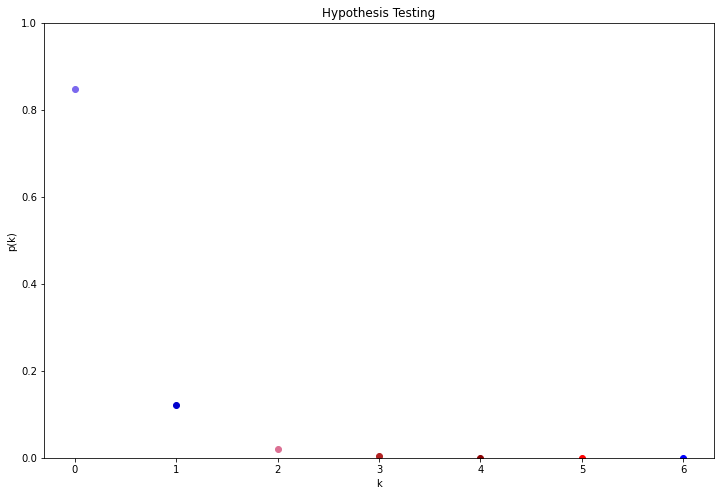

In [137]:
"""
MAYBE WE NEED TO SPLIT THE CHART INTO 7 CHARTS
"""

# create figure 
fig = plt.figure(figsize=(12, 8))

# add plot
ax = fig.add_subplot(1, 1, 1)

colors = ['mediumslateblue', 'mediumblue', 'palevioletred', 'firebrick', 'darkred', 'red', 'blue', 'yellow']

for i in range(len(k_pk_table)):

    # data series
    x = k_pk_table.loc[i, 'k']
    y = k_pk_table.loc[i, 'simul_mean']
    y_high = k_pk_table.loc[i, 'upper_bound']
    y_low = k_pk_table.loc[i, 'lower_bound']

    # plot data
    ax.errorbar(x, y, fmt='o',
                yerr=np.absolute(y_low - y_high)/2,
                elinewidth=1,
                markerfacecolor = colors[i],
                markeredgecolor = colors[i],
                ecolor = colors[i]
                )    

# set ticks and title

ax.set_ylim(0, 1)
# ax.set_xticks(np.arange(len(k_pk_table)))
# ax.set_yticks(np.arange(-0.4, -0.1, 0.1))
ax.set_xlabel('k')
ax.set_ylabel('p(k)')
ax.set_title('Hypothesis Testing')


plt.show()

## Homophily-Performance Analysis

In [44]:
df

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name
0,AS Monaco,Aadil Assana,20.0,Defensive Midfield,Clermont Foot,"End of loanJun 30, 2013",in,0.000,2013,1,2,NaN,[]
1,AS Monaco,Aadil Assana,20.0,Defensive Midfield,CA Bastia,"End of loanJan 20, 2014",in,0.000,2013,2,2,0.0,[]
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2,NaN,[]
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2,1.0,[Jacob Burns]
4,Bristol City,Aaron Amadi-Holloway,18.0,Centre-Forward,Bristol City U18,-,in,0.000,2011,1,2,NaN,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
78620,SC Freiburg,Zvonko Pamic,19.0,Central Midfield,Bay. Leverkusen,Loan,in,0.000,2010,2,5,0.0,[]
78621,Bayer 04 Leverkusen,Zvonko Pamic,20.0,Central Midfield,SC Freiburg,"End of loanJun 30, 2011",in,0.000,2011,3,5,0.0,[]
78622,Bayer 04 Leverkusen,Zvonko Pamic,21.0,Central Midfield,MSV Duisburg,"End of loanJun 30, 2012",in,0.000,2012,4,5,14.0,"[Sidney Sam, Andre Schurrle, Manuel Friedrich,..."
78623,Bayer 04 Leverkusen,Zvonko Pamic,21.0,Central Midfield,MSV Duisburg,"End of loanDec 31, 2012",in,0.000,2012,5,5,14.0,"[Sidney Sam, Andre Schurrle, Manuel Friedrich,..."


### Performance Analysis (Fee)

In [62]:
perf_eval_df.head()

,club_name,player_name,age,position,club_involved_name,transfer_movement,fee_cleaned,year,adjusted_fee
0,Ajax Amsterdam,Marc Overmars,19.0,Left Winger,Willem II,in,0.817,1992,0.540411
1,Ajax Amsterdam,Jari Litmanen,21.0,Attacking Midfield,MYPA,in,0.013,1992,0.006954
2,Ajax Amsterdam,Aron Winter,25.0,Defensive Midfield,Lazio,out,1.170,1992,0.551210
3,Sparta Rotterdam,Winston Bogarde,21.0,Centre-Back,Excelsior,in,0.005,1992,0.002674
4,Willem II Tilburg,Marc Overmars,19.0,Left Winger,Ajax,out,0.817,1992,0.540411


In [63]:
adj_coef_table.head()

,age,coef
0,15.0,1.000000
1,16.0,1.000000
2,17.0,1.000000
3,18.0,0.784209
4,19.0,0.661457


In [65]:
# add `adjusted_fee` column which adjusted for player's age
perf_eval_df = pd.merge(perf_eval_df, adj_coef_table, on='age', how='left')
perf_eval_df['adjusted_fee'] = np.multiply(perf_eval_df['fee_cleaned'],
                                           perf_eval_df['coef'])

# remove `coef` column
perf_eval_df.drop(columns=['coef', 'position', 'club_involved_name'], inplace=True)
perf_eval_df.head()

,club_name,player_name,age,transfer_movement,fee_cleaned,year,adjusted_fee
0,Ajax Amsterdam,Marc Overmars,19.0,in,0.817,1992,0.540411
1,Ajax Amsterdam,Jari Litmanen,21.0,in,0.013,1992,0.006954
2,Ajax Amsterdam,Aron Winter,25.0,out,1.170,1992,0.551210
3,Sparta Rotterdam,Winston Bogarde,21.0,in,0.005,1992,0.002674
4,Willem II Tilburg,Marc Overmars,19.0,out,0.817,1992,0.540411


In [66]:
merge_on = ['club_name', 'player_name', 'age', 'transfer_movement', 'fee_cleaned', 'year']
perf_eval_table = pd.merge(df, perf_eval_df, on = merge_on, how = 'left')
perf_eval_table.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name,adjusted_fee
0,AS Monaco,Aadil Assana,20.0,Defensive Midfield,Clermont Foot,"End of loanJun 30, 2013",in,0.000,2013,1,2,NaN,[],NaN
1,AS Monaco,Aadil Assana,20.0,Defensive Midfield,CA Bastia,"End of loanJan 20, 2014",in,0.000,2013,2,2,0.0,[],NaN
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2,NaN,[],0.333374
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2,1.0,[Jacob Burns],0.108584
4,Bristol City,Aaron Amadi-Holloway,18.0,Centre-Forward,Bristol City U18,-,in,0.000,2011,1,2,NaN,[],NaN


In [61]:
# only select the players that have at least two transfers to see the improvement
target_player = list(perf_eval_table[perf_eval_table['num_transfer'] > 1]['player_name'])

perf_eval_table = perf_eval_table[perf_eval_table['player_name'].isin(target_player)]
perf_eval_table.reset_index(drop=True, inplace=True)
print(f'number of observation: {len(perf_eval_table)}')
perf_eval_table.head()

number of observation: 66474


,club_name,player_name,age,position_x,club_involved_name_x,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name,position_y,club_involved_name_y,adjusted_fee
0,AS Monaco,Aadil Assana,20.0,Defensive Midfield,Clermont Foot,"End of loanJun 30, 2013",in,0.000,2013,1,2,NaN,[],NaN,NaN,NaN
1,AS Monaco,Aadil Assana,20.0,Defensive Midfield,CA Bastia,"End of loanJan 20, 2014",in,0.000,2013,2,2,0.0,[],NaN,NaN,NaN
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2,NaN,[],Centre-Back,HJK Helsinki,0.333374
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2,1.0,[Jacob Burns],Centre-Back,Leeds,0.108584
4,Bristol City,Aaron Amadi-Holloway,18.0,Centre-Forward,Bristol City U18,-,in,0.000,2011,1,2,NaN,[],NaN,NaN,NaN


In [72]:
# only select transfers that include money transfer
perf_eval_table = perf_eval_table[perf_eval_table['adjusted_fee'].notna()]
print(f'number of observation: {len(perf_eval_table)}')
perf_eval_table.head()

number of observation: 15673


,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name,adjusted_fee
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2,NaN,[],0.333374
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2,1.0,[Jacob Burns],0.108584
18,Reading FC,Aaron Brown,22.0,Centre-Back,Tamworth,£135Th.,in,0.135,2005,6,9,1.0,[Leroy Lita],0.067819
26,Wolverhampton Wanderers,Aaron Collins,18.0,Centre-Forward,Newport County,£69Th.,in,0.069,2015,1,6,NaN,[],0.054110
33,Ipswich Town,Aaron Cresswell,21.0,Left-Back,Tranmere Rovers,£248Th.,in,0.248,2011,1,2,NaN,[],0.132654


In [73]:
# change in fee as a proxy of performance --> `perf_change`
perf_eval_table['perf_change'] = perf_eval_table.groupby('player_name')['fee_cleaned'].pct_change()

In [74]:
# change in adjusted fee as a proxy of performance --> `perf_change_adjusted`
group = perf_eval_table.groupby('player_name')
perf_eval_table['perf_change_adjusted'] = group['adjusted_fee'].pct_change()

In [76]:
perf_eval_table

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name,adjusted_fee,perf_change,perf_change_adjusted
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2,NaN,[],0.333374,NaN,NaN
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2,1.0,[Jacob Burns],0.108584,-0.597222,-0.674288
18,Reading FC,Aaron Brown,22.0,Centre-Back,Tamworth,£135Th.,in,0.135,2005,6,9,1.0,[Leroy Lita],0.067819,NaN,NaN
26,Wolverhampton Wanderers,Aaron Collins,18.0,Centre-Forward,Newport County,£69Th.,in,0.069,2015,1,6,NaN,[],0.054110,NaN,NaN
33,Ipswich Town,Aaron Cresswell,21.0,Left-Back,Tranmere Rovers,£248Th.,in,0.248,2011,1,2,NaN,[],0.132654,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78794,Alania Vladikavkaz,Zurab Menteshashvili,22.0,Central Midfield,Skonto Riga,£180k,in,0.180,2002,1,2,NaN,[],0.090426,NaN,NaN
78804,VfL Wolfsburg,Zvjezdan Misimovic,26.0,Attacking Midfield,1.FC Nuremberg,£3.60m,in,3.600,2008,3,4,0.0,[],1.722852,NaN,NaN
78805,Dinamo Moscow,Zvjezdan Misimovic,28.0,Attacking Midfield,Galatasaray,£4.05m,in,4.050,2010,4,4,0.0,[],2.122770,0.125000,0.232125
78808,VfB Stuttgart,Zvonimir Soldo,28.0,Defensive Midfield,Croatia Zagreb,£900Th.,in,0.900,1996,1,1,NaN,[],0.471727,NaN,NaN


In [77]:
# get `k-perf` table
k_perf = perf_eval_table[['k', 'perf_change', 'perf_change_adjusted']].dropna()
k_perf.head()

,k,perf_change,perf_change_adjusted
3,1.0,-0.597222,-0.674288
34,1.0,16.258065,14.239675
48,1.0,0.000000,0.051844
63,25.0,4.000000,2.341844
64,1.0,-0.716667,-0.656150


In [83]:
# get average fee change per k
k_perf_plot = pd.DataFrame(
    k_perf.groupby('k')['perf_change_adjusted'].agg(['median',
                                                     'count'])).reset_index()
# use the same k-threshold as homophily analysis
xmax = 6
k_perf_plot = k_perf_plot[k_perf_plot['k'] <= xmax]

In [84]:
k_perf_plot

,k,median,count
0,0.0,0.325797,2862
1,1.0,0.274839,1218
2,2.0,0.191991,507
3,3.0,-0.050725,227
4,4.0,0.049107,107
5,5.0,0.017381,49
6,6.0,-0.231824,32


Text(0.5, 1.0, 'Performance - Homophily (adjusted)')

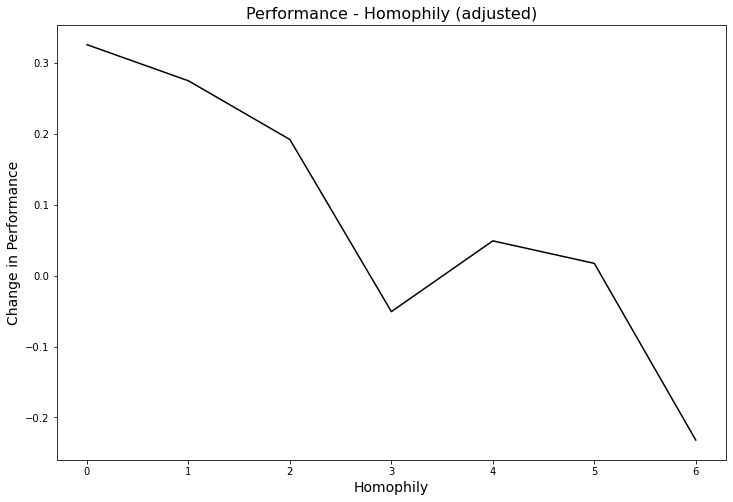

In [87]:
fig = plt.figure(figsize=(12, 8))

ax = fig.add_subplot(1, 1, 1)

"""Performance-Homophily with age adjustment"""
ax.plot(k_perf_plot['k'], k_perf_plot['median'], color='black')

ax.set_xlabel('Homophily', size=14)
ax.set_ylabel('Change in Performance', size=14)
ax.set_title('Performance - Homophily (adjusted)', size=16)

## Tenure Analysis
Data is not sorted properly, tenure analysis cant be done

In [88]:
df.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name
0,AS Monaco,Aadil Assana,20.0,Defensive Midfield,Clermont Foot,"End of loanJun 30, 2013",in,0.000,2013,1,2,NaN,[]
1,AS Monaco,Aadil Assana,20.0,Defensive Midfield,CA Bastia,"End of loanJan 20, 2014",in,0.000,2013,2,2,0.0,[]
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2,NaN,[]
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2,1.0,[Jacob Burns]
4,Bristol City,Aaron Amadi-Holloway,18.0,Centre-Forward,Bristol City U18,-,in,0.000,2011,1,2,NaN,[]


In [90]:
# get number of years in the club
num_year_stay = []
for i in tqdm(range(len(df))):
    if df['num_transfer'][i] < df['max_transfer'][i]:
        val = df['year'][i + 1] - df['year'][i]
        num_year_stay.append(val)
    else:
        val = max(df['year']) - df['year'][i]
        num_year_stay.append(val)
df['num_year_stay'] = num_year_stay
df.head()

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name,num_year_stay
0,AS Monaco,Aadil Assana,20.0,Defensive Midfield,Clermont Foot,"End of loanJun 30, 2013",in,0.000,2013,1,2,NaN,[],0
1,AS Monaco,Aadil Assana,20.0,Defensive Midfield,CA Bastia,"End of loanJan 20, 2014",in,0.000,2013,2,2,0.0,[],7
2,Leeds United,Aapo Halme,19.0,Centre-Back,HJK Helsinki,£504Th.,in,0.504,2017,1,2,NaN,[],2
3,Barnsley FC,Aapo Halme,21.0,Centre-Back,Leeds,£203Th.,in,0.203,2019,2,2,1.0,[Jacob Burns],1
4,Bristol City,Aaron Amadi-Holloway,18.0,Centre-Forward,Bristol City U18,-,in,0.000,2011,1,2,NaN,[],0


In [ ]:
# average number of year stayed by k
for_num_year = df[['num_year_stay', 'k']].dropna()

In [ ]:
num_year_df = pd.DataFrame(
    for_num_year.groupby('k')['num_year_stay'].agg(['mean',
                                                    'count'])).reset_index()
num_year_df.head()

In [ ]:
# get `k-perf` table
k_perf = df[['k', 'perf_change', 'perf_change_adjusted']].dropna()
k_perf.head()

In [ ]:
k_perf.sort_values(by='k', ascending=False).head()

In [ ]:
pd.DataFrame(k_perf.groupby('k')['perf_change'].agg(['median',
                                                     'count'])).reset_index()

In [ ]:
pd.DataFrame(
    k_perf.groupby('k')['perf_change_adjusted'].agg(['median',
                                                     'count'])).reset_index()

#### Visualization

In [ ]:
# get average perf_change by k
table = pd.DataFrame(k_perf.groupby('k')['perf_change']\
                     .agg(['mean', 'median', 'mad', 'count'])).reset_index()

In [ ]:
table['pk'] = table['count'] / sum(table['count'])

In [ ]:
# get average perf_change_adjusted by k
table2 = pd.DataFrame(k_perf.groupby('k')['perf_change_adjusted']\
                      .agg(['mean', 'median', 'mad', 'count'])).reset_index()

In [ ]:
table2['pk'] = table['count'] / sum(table['count'])

In [ ]:
# get the index where `count` >= 30
xmax = max(table[table['count'] >= 30].index)

table = table[:xmax + 1]
table2 = table2[:xmax + 1]

In [ ]:
# set-up
table.rename(columns={'median': 'med_perf_change'}, inplace=True)
table

In [ ]:
# set-up
table2.rename(columns={'median': 'med_perf_change'}, inplace=True)
table2

In [ ]:
# set-up
num_year_df = num_year_df[:xmax + 1]
num_year_df.rename(columns={'mean': 'average_year_stayed'}, inplace=True)
num_year_df

In [ ]:
fig = plt.figure(figsize=(14, 14))

ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
ax3 = fig.add_subplot(2, 2, 4)
"""Performance-Homophily without age adjustment"""
ax0.plot(table['k'], table['med_perf_change'], color='black')

ax0.set_xlabel('Homophily', size=14)
ax0.set_ylabel('Change in Performance', size=14)
ax0.set_title('Performance - Homophily', size=16)

# get x limit
ylim = ax0.get_ylim()

# ax0.set_xlim((0,xmax))
# ax0.set_ylim((-1,1))
"""Performance-Homophily with age adjustment"""
ax1.plot(table['k'], table2['med_perf_change'], color='black')

ax1.set_xlabel('Homophily', size=14)
ax1.set_ylabel('Change in Performance', size=14)
ax1.set_title('Performance - Homophily (adjusted)', size=16)

# ax1.set_xlim((0,xmax))
ax1.set_ylim(ylim)
"""Tenure-Homophily"""
ax2.bar(x=num_year_df['k'], height=num_year_df['average_year_stayed'])

ax2.set_xlabel('Homophily', size=14)
ax2.set_ylabel('Tenure', size=14)
ax2.set_title('Tenure - Homophily', size=16)

# ax2.set_xlim((-1,xmax))
"""k-count (Homophily)"""
ax3.bar(x=table['k'], height=table['pk'])

ax3.set_xlabel('k', size=14)
ax3.set_ylabel('pk', size=14)
ax3.set_title('k - pk (Homophily)', size=16)

plt.show()

## Top player similarity analysis

In [139]:
rating_df = pd.read_csv(os.path.join(cleaned_data_path, 'player_rating.csv'))

In [140]:
rating_eval_df = pd.merge(perf_eval_df,
                          rating_df,
                          on=['player_name', 'year'],
                          how='inner')

In [143]:
rating_eval_df

,club_name,player_name,age,transfer_movement,fee_cleaned,year,adjusted_fee,overall_rating
0,PSV Eindhoven,Danny Koevermans,28.0,in,6.21,2007,3.254914,70.0
1,AZ Alkmaar,Danny Koevermans,28.0,out,6.21,2007,3.254914,70.0
2,PSV Eindhoven,Danko Lazovic,24.0,in,5.40,2007,2.550630,75.5
3,Vitesse Arnhem,Danko Lazovic,24.0,out,5.40,2007,2.550630,75.5
4,PSV Eindhoven,Kenneth Perez,32.0,in,0.90,2007,0.831630,77.0
...,...,...,...,...,...,...,...,...
8791,Deportivo de La Coruña,Przemyslaw Tyton,29.0,in,0.45,2016,0.255790,76.0
8792,Real Sociedad,Willian Jose,24.0,in,5.40,2016,2.550630,71.0
8793,Valencia CF,Nani,29.0,in,7.65,2016,4.348427,82.0
8794,CA Osasuna,Fran Merida,26.0,in,0.45,2016,0.215357,71.0


In [144]:
rating_eval_df = pd.DataFrame(
    rating_eval_df.groupby(['player_name', 'age'])['overall_rating'].agg('mean'))
rating_eval_df.reset_index(inplace=True)
top_player_list = rating_eval_df[
    rating_eval_df['overall_rating'] > 85]['player_name'].unique()
top_player_list

array(['Angel Di Maria', 'Arjen Robben', 'Arturo Vidal',
       'Bastian Schweinsteiger', 'Carlos Tevez', 'Cesc Fabregas',
       'Cristiano Ronaldo', 'David Silva', 'David Villa',
       'Dimitar Berbatov', 'Eden Hazard', 'Edinson Cavani',
       'Ezequiel Lavezzi', 'Fernando Torres', 'Franck Ribery',
       'Gabriel Milito', 'Gareth Bale', 'Gonzalo Higuain', 'Hugo Lloris',
       'James Rodriguez', 'Juan Mata', 'Luca Toni', 'Lucio',
       'Luis Suarez', 'Luka Modric', 'Manuel Neuer', 'Mario Gomez',
       'Mats Hummels', 'Miroslav Klose', 'Paul Pogba',
       'Rafael van der Vaart', 'Robin van Persie', 'Ronaldinho',
       'Roy Makaay', 'Samir Nasri', "Samuel Eto'o", 'Sergio Aguero',
       'Thiago Silva', 'Thierry Henry', 'Wesley Sneijder', 'Ze Roberto',
       'Zlatan Ibrahimovic'], dtype=object)

In [147]:
top_eval = perf_eval_table[perf_eval_table['player_name'].isin(top_player_list)]

In [148]:
top_eval[top_eval['num_transfer'] >= 3][[
    'club_name', 'player_name', 'age', 'year', 'club_involved_name',
    'adjusted_fee', 'k', 'perf_change_adjusted'
]].sort_values(by='year')

,club_name,player_name,age,year,club_involved_name,adjusted_fee,k,perf_change_adjusted
65516,Deportivo de La Coruña,Roy Makaay,24.0,1999,CD Tenerife,3.655903,1.0,0.347661
72531,Arsenal FC,Thierry Henry,21.0,1999,Juventus,7.750657,0.0,0.288000
67114,RCD Mallorca,Samuel Eto'o,18.0,1999,Real Madrid,3.176046,0.0,NaN
78558,Bayern Munich,Ze Roberto,27.0,2002,Bay. Leverkusen,4.236900,0.0,0.394220
65517,Bayern Munich,Roy Makaay,28.0,2003,Dep. La Coruña,9.319222,0.0,1.549089
...,...,...,...,...,...,...,...,...
12249,AS Monaco,Cesc Fabregas,31.0,2018,Chelsea,6.015951,1.0,-0.591242
7892,FC Barcelona,Arturo Vidal,31.0,2018,Bayern Munich,12.031901,1.0,-0.350255
50313,Borussia Dortmund,Mats Hummels,30.0,2019,Bayern Munich,17.460695,5.0,0.118585
20729,Real Madrid,Eden Hazard,28.0,2019,Chelsea,54.248566,1.0,2.219642


In [149]:
pd.DataFrame(top_eval.groupby('club_name')['transfer_movement'].agg('count'))\
.sort_values(by = 'transfer_movement', ascending = False)

,transfer_movement
club_name,
Real Madrid,11
Bayern Munich,11
FC Barcelona,9
Manchester United,7
Juventus FC,6
Paris Saint-Germain,6
Tottenham Hotspur,5
Chelsea FC,5
Manchester City,4


In [157]:
player_in_madrid = top_eval[top_eval['club_name'] ==
                            'Real Madrid']['player_name'].unique()
player_in_bayern = top_eval[top_eval['club_name'] ==
                            'Bayern Munich']['player_name'].unique()
player_in_barcelona = top_eval[top_eval['club_name'] ==
                            'FC Barcelona']['player_name'].unique()

In [158]:
top_eval[top_eval['player_name'].isin(player_in_madrid)]

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name,adjusted_fee,perf_change,perf_change_adjusted
6331,SL Benfica,Angel Di Maria,19.0,Right Winger,CA Rosario,£7.20m,in,7.20,2007,1,4,NaN,[],4.762492,NaN,NaN
6332,Real Madrid,Angel Di Maria,22.0,Right Winger,Benfica,£29.70m,in,29.70,2010,2,4,0.0,[],14.920267,3.125000,2.132870
6333,Manchester United,Angel Di Maria,26.0,Right Winger,Real Madrid,£67.50m,in,67.50,2014,3,4,0.0,[],32.303477,1.272727,1.165074
6334,Paris Saint-Germain,Angel Di Maria,27.0,Right Winger,Man Utd,£56.70m,in,56.70,2015,4,4,1.0,[David Luiz],28.097335,-0.160000,-0.130207
7405,PSV Eindhoven,Arjen Robben,18.0,Right Winger,FC Groningen,£3.87m,in,3.87,2002,2,6,0.0,[],3.034889,NaN,NaN
7406,Chelsea FC,Arjen Robben,20.0,Right Winger,PSV Eindhoven,£16.20m,in,16.20,2004,3,6,2.0,"[Eidur Gudjohnsen, Mateja Kezman]",9.474073,3.186047,2.121720
7407,Real Madrid,Arjen Robben,23.0,Right Winger,Chelsea,£31.50m,in,31.50,2007,4,6,0.0,[],15.194519,0.944444,0.603800
7408,Bayern Munich,Arjen Robben,25.0,Right Winger,Real Madrid,£22.50m,in,22.50,2009,5,6,1.0,[Mark van Bommel],10.600184,-0.285714,-0.302368
14804,Manchester United,Cristiano Ronaldo,18.0,Left Winger,Sporting CP,£17.10m,in,17.10,2003,2,4,0.0,[],13.409973,NaN,NaN
14805,Real Madrid,Cristiano Ronaldo,24.0,Left Winger,Man Utd,£84.60m,in,84.60,2009,3,4,0.0,[],39.959872,3.947368,1.979862


In [159]:
top_eval[top_eval['player_name'].isin(player_in_bayern)]

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name,adjusted_fee,perf_change,perf_change_adjusted
7405,PSV Eindhoven,Arjen Robben,18.0,Right Winger,FC Groningen,£3.87m,in,3.870,2002,2,6,0.0,[],3.034889,NaN,NaN
7406,Chelsea FC,Arjen Robben,20.0,Right Winger,PSV Eindhoven,£16.20m,in,16.200,2004,3,6,2.0,"[Eidur Gudjohnsen, Mateja Kezman]",9.474073,3.186047,2.121720
7407,Real Madrid,Arjen Robben,23.0,Right Winger,Chelsea,£31.50m,in,31.500,2007,4,6,0.0,[],15.194519,0.944444,0.603800
7408,Bayern Munich,Arjen Robben,25.0,Right Winger,Real Madrid,£22.50m,in,22.500,2009,5,6,1.0,[Mark van Bommel],10.600184,-0.285714,-0.302368
7889,Bayer 04 Leverkusen,Arturo Vidal,20.0,Central Midfield,Colo Colo,£4.68m,in,4.680,2007,1,5,NaN,[],2.736954,NaN,NaN
7890,Juventus FC,Arturo Vidal,24.0,Central Midfield,Bay. Leverkusen,£11.25m,in,11.250,2011,2,5,0.0,[],5.313813,1.403846,0.941506
7891,Bayern Munich,Arturo Vidal,28.0,Central Midfield,Juventus,£35.33m,in,35.330,2015,3,5,1.0,[Kingsley Coman],18.517892,2.140444,2.484860
7892,FC Barcelona,Arturo Vidal,31.0,Central Midfield,Bayern Munich,£16.20m,in,16.200,2018,4,5,1.0,[Rafinha],12.031901,-0.541466,-0.350255
25467,Bayern Munich,Franck Ribery,24.0,Left Winger,Marseille,£27.00m,in,27.000,2007,3,4,0.0,[],12.753151,NaN,NaN
44770,Brescia Calcio,Luca Toni,24.0,Centre-Forward,Vicenza,£4.50m,in,4.500,2001,2,10,0.0,[],2.125525,NaN,NaN


In [160]:
top_eval[top_eval['player_name'].isin(player_in_barcelona)]

,club_name,player_name,age,position,club_involved_name,fee,transfer_movement,fee_cleaned,year,num_transfer,max_transfer,k,k_name,adjusted_fee,perf_change,perf_change_adjusted
7889,Bayer 04 Leverkusen,Arturo Vidal,20.0,Central Midfield,Colo Colo,£4.68m,in,4.68,2007,1,5,NaN,[],2.736954,NaN,NaN
7890,Juventus FC,Arturo Vidal,24.0,Central Midfield,Bay. Leverkusen,£11.25m,in,11.25,2011,2,5,0.0,[],5.313813,1.403846,0.941506
7891,Bayern Munich,Arturo Vidal,28.0,Central Midfield,Juventus,£35.33m,in,35.33,2015,3,5,1.0,[Kingsley Coman],18.517892,2.140444,2.484860
7892,FC Barcelona,Arturo Vidal,31.0,Central Midfield,Bayern Munich,£16.20m,in,16.20,2018,4,5,1.0,[Rafinha],12.031901,-0.541466,-0.350255
12246,Arsenal FC,Cesc Fabregas,16.0,Central Midfield,Barça U16,£2.88m,in,2.88,2003,1,4,NaN,[],2.880000,NaN,NaN
12247,FC Barcelona,Cesc Fabregas,24.0,Central Midfield,Arsenal,£30.60m,in,30.60,2011,2,4,0.0,[],14.453571,9.625000,4.018601
12248,Chelsea FC,Cesc Fabregas,27.0,Central Midfield,FC Barcelona,£29.70m,in,29.70,2014,3,4,0.0,[],14.717652,-0.029412,0.018271
12249,AS Monaco,Cesc Fabregas,31.0,Central Midfield,Chelsea,£8.10m,in,8.10,2018,4,4,1.0,[Falcao],6.015951,-0.727273,-0.591242
17805,Valencia CF,David Villa,23.0,Centre-Forward,Real Zaragoza,£10.80m,in,10.80,2005,1,3,NaN,[],5.209549,NaN,NaN
17806,FC Barcelona,David Villa,28.0,Centre-Forward,Valencia,£36.00m,in,36.00,2010,2,3,0.0,[],18.869066,2.333333,2.622015
